## Classifying discrete spacetimes by dimension

Note: Breaks on M1 Macs because of `tensorflow` causing kernel panic.

[The causal set approach to quantum gravity](https://link.springer.com/article/10.1007/s41114-019-0023-1) postulates spacetime is fundamentally comprised of a set of "spacetime atoms", also called elements, together with a set of pairwise causal relations. This approach is deeply rooted in discrete geometry and topology, as well as order theory, and it appeals to practitioners who are minimalists in terms of underlying assumptions of fundamental physics.  While there are many interesting open problems connecting the discrete, quantum world to the continuous, classical realm we are familiar with, in this tutorial we focus on a relatively simple question: is it possible, using machine learning methods, to infer the embedding dimension of a finite causal set spacetime?  If so, what are some of the challenges in accurately measuring such an observable, particularly for small spacetimes on the order of 100 Planck volumes ($10^{-103}m^3$)?

We start by importing Covalent, as well as some other relevant libraries:

In [1]:
import covalent as ct
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import List, Tuple

## Data Generation

In the first part we generate training data for the ML task. Each sample is a sequence of $N$ integers which characterize a single discrete flat spacetime. Samples are generated for either 2D or 3D spacetimes using [Poisson sampling](https://en.wikipedia.org/wiki/Poisson_point_process) in a unit-height Alexandroff interval.  Each coordinate represents an atom of spacetime, also called an element.  Once elements are sampled, we calculate the adjacency matrix of causal relations. A relation "$\prec$" is said to exist between a pair of spacetime elements $(x,y)$ iff they are timelike separated, i.e., if a signal can travel between the points at less than the speed of light.  At this point each spacetime is characterized by $O(N^2)$ degrees of freedom. However, the topology and geometry can be characterized by $O(N)$ degrees of freedom by calculating the size distribution of the "order intervals". That is, for each pair of elements $(x,y)$, with $x\prec y$ count the number of elements $z$ which satisfy $x\prec z\prec y$. The distribution of these sizes describes the distribution of neighborhood sizes in Lorentzian spaces.

In [2]:
# Generate a single spacetime
@ct.electron
def generate_flat_spacetime(
    num_elements: int = 100, 
    dim: int = 2
) -> pd.DataFrame:
    
    if dim == 2:
        # Sample light cone coordinates in 2D
        u = np.random.random(num_elements)
        v = np.random.random(num_elements)
        
        # Rotate to Lorentzian coordinates
        t = (u + v) / np.sqrt(2)
        x = (u - v) / np.sqrt(2)
        
        # Format the coordinates in a dataframe
        df = pd.DataFrame(zip(x,t), columns=['x','t'])
        df.sort_values('t', inplace=True, ignore_index=True)
        return df
    elif dim == 3:
        # Sample light cone coordinates in 3D
        u = np.random.random(num_elements) ** (1. / 3)
        v = u - np.sqrt(u * u * (1 - np.random.random(num_elements)))
        theta = 2 * np.pi * np.random.random(num_elements)
        
        # Coordinate transformation
        t = (u + v) / np.sqrt(2)
        x = ((u - v) / np.sqrt(2)) * np.cos(theta)
        y = ((u - v) / np.sqrt(2)) * np.sin(theta)
        
        # Format the coordinates in a dataframe
        df = pd.DataFrame(zip(x,y,t), columns=['x','y','t'])
        df.sort_values('t', inplace=True)
        return df
    else:
        raise Exception(f"Dimension {dim} is not supported!")

# Visualize a single spacetime
def visualize_spacetime(coords: pd.DataFrame) -> None:
    
    dim = len(coords.columns)
    
    if dim == 2:
        ax = coords.plot.scatter(x='x', y='t')
        ax.set_aspect('equal')
        ax.set_facecolor('white')
    elif dim == 3:
        ax = coords.plot.scatter(x='x', y='t')
        ax.set_aspect('equal')
        ay = coords.plot.scatter(x='x', y='y')
        ay.set_aspect('equal')
    else:
        raise Exception(f"Dimension {dim} is not supported!")

Let's pause here to visualize a single discrete spacetime.  We execute the function `generate_flat_spacetime` directly by wrapping it as a lattice and dispatching it. In two dimensions, for instance, we see the region is a diamond shape:

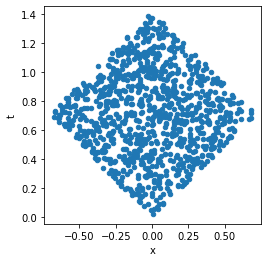

In [3]:
dispatch_id = ct.dispatch(ct.lattice(generate_flat_spacetime))(num_elements=1000, dim=2)
coordinates = ct.get_result(dispatch_id, wait=ct.wait.LONG).result
visualize_spacetime(coordinates)

Now we generate an ensemble of such spacetimes and calculate the causal relations for each:

In [4]:
# Generate an ensemble of spacetimes
@ct.electron
def generate_ensemble(
    ensemble_size: int = 1000, 
    num_elements: int = 100, 
    dim: int = 2
) -> pd.DataFrame:
    
    return pd.concat([
        generate_flat_spacetime(num_elements=num_elements, dim=dim) \
        for x in range(ensemble_size)
    ], ignore_index=True)

In [5]:
# Identify causal relations between elements
@ct.electron
def is_related(
    c1: pd.DataFrame, 
    c2: pd.DataFrame, 
    dim: int
) -> bool:
    
    related = False
    
    if dim == 2:
        dx = abs(c1['x'] - c2['x'])
        dt = abs(c1['t'] - c2['t'])

        related = dx < dt
    elif dim == 3:
        dx = np.sqrt((c1['x'] - c2['x']) ** 2 + (c1['y'] - c2['y']) ** 2)
        dt = abs(c1['t'] - c2['t'])
        
        related = dx < dt
    else:
        raise Exception(f"Dimension {dim} is not supported!")
    
    return related

# Generate adjacency matrices
@ct.electron
def generate_adj_matrices(
    ensemble: pd.DataFrame,
    num_elements: int, dim: int
) -> np.ndarray:
    
    num_spacetimes = int(ensemble.shape[0] / num_elements)
    adjmat = np.zeros((num_spacetimes,num_elements,num_elements), dtype=bool)
    
    for st in range(num_spacetimes):
        coords = ensemble[st*num_elements:(st+1)*num_elements]
        for i, c in coords.iterrows():
            for j, d in coords.iterrows():
                adjmat[st,i%num_elements,j%num_elements] = is_related(c1=c, c2=d, dim=dim)
    
    return adjmat

In [6]:
# Calculate order intervals
# Reduces d.o.f. to O(num_elements)
@ct.electron
def calculate_intervals(
    adjmat: np.ndarray
) -> pd.DataFrame:
    
    num_spacetimes = len(adjmat)
    num_elements = len(adjmat[0,0])
    
    intervals = np.zeros((num_spacetimes, num_elements), dtype=float)
    for st, A in enumerate(adjmat):
        intervals[st,0] = num_elements
        for i in range(num_elements):
            for j in range(i + 1, num_elements):
                count = 0
                for k in range(i + 1, j):
                    count += int(A[i,k] and A[k,j])
                intervals[st,count+1] += 1
    
    return pd.DataFrame(intervals)

# Calculate all intervals across dimensions
@ct.electron
def calculate_all_intervals(
    relations: List[np.ndarray]
) -> pd.DataFrame:
    
    return pd.concat([
        calculate_intervals(adjmat=r) for r in relations
    ], ignore_index=True)

In [7]:
# Construct training classes
@ct.electron
def construct_classes(
    nsamples: int, 
    dimensions: List[int]
) -> pd.DataFrame:
    
    classes = pd.DataFrame()
    
    for idx, dim in enumerate(dimensions):
        classes[f"{dim}D"] = pd.concat([
            pd.Series([0 for x in range(nsamples*idx)], dtype=float),
            pd.Series([1 for x in range(nsamples)], dtype=float),
            pd.Series([0 for x in range(
                nsamples*(idx+1), 
                nsamples*len(dimensions)
            )], dtype=float)
        ], ignore_index=True)
        
    return classes

In order to generate the training data, we now combine the above functions into a lattice. There are three computationally heavy tasks which we serialize: the $O(N)$ coordinate sampling, the $O(N^2)$ relations calculation, and the $O(N^3)$ order interval calculation.

In [8]:
# Lattice to generate the data
@ct.lattice
def generate_training_data(
    nsamples, 
    num_elements, 
    dimensions
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    # Generate the coordinate ensemble
    spacetimes = [ 
        generate_ensemble(
            ensemble_size=nsamples, 
            num_elements=num_elements, 
            dim=d
        ) 
        for d in dimensions
    ]
    
    # Calculate causal relations
    relations = [
        generate_adj_matrices(
            ensemble=st,
            num_elements=num_elements,
            dim=d
        ) for st, d in zip(spacetimes, dimensions)
    ]
    
    # Calculate order intervals (learning model inputs)
    predictors = calculate_all_intervals(relations=relations)
    
    # Construct training classes (learning model outputs)
    classes = construct_classes(nsamples=nsamples, dimensions=dimensions)
    
    return predictors, classes

Let's now visualize the workflow we've constructed so far:

In [9]:
# Workflow parameters
nsamples = 100
size = 20
dims = [2, 3]

params = {
    'nsamples': nsamples,
    'num_elements': size,
    'dimensions': dims
}

# Visualize workflow graph on the GUI
dispatch_id = ct.dispatch(generate_training_data)(
    nsamples=nsamples, 
    num_elements=size, 
    dimensions=dims
)
print(dispatch_id)

# Navigate to localhost:48008 in your browser and examine the latest dispatch entry

9d5d0bd7-cd20-4ae2-802f-49071a5109a4


![Data generation workflow diagram](./qg_workflow_1.png)

For any of these electrons, represented by nodes in the workflow graph, we can inspect status, query inputs and outputs, debug if there are error messages, and even re-run if a portion failed.  Features like these are useful if, for instance, we had a bug in the code which generated three-dimensional spacetimes.  In this case we could retain the correct two-dimensional data, make required changes to the code, and re-dispatch the lattice to complete the workflow.

## Constructing the Learning Model

We continue now by constructing a learning model. We use a five-layer deep neural network trained with supervised learning. The network architecture is chosen such that the size of the layers uniformly decreases with depth, and the learning rate has been selected such that the training procedure converges in a reasonable time.  We also use batch training, i.e., the training operation occurs using randomized batches of 10% of the dataset each epoch, so that the model converges quickly and generalizes well.

In [10]:
# Architecture of the deep neural network

# The number of input neurons is equal to the problem size
num_inputs = size
# The number of outputs is equal to the number of classes
num_outputs = len(dims)
# We use three hidden layers which decrease in size
num_hidden = [ int(0.75*num_inputs), int(0.5*num_inputs), int(0.25*num_inputs) ]
# Total number of layers in the neural network
num_layers = 2 + len(num_hidden)
# Layer sizes
layer_sizes = [ num_inputs ] + num_hidden + [ num_outputs ]
# Assert the sizes are decreasing
assert(num_inputs > num_hidden[0])
assert(num_hidden[-1] > num_outputs)

In [11]:
# Shuffle the data
@ct.electron
def shuffle_training_data(
    predictors: pd.DataFrame, 
    classes: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    num_inputs = len(predictors.columns)
    num_outputs = len(classes.columns)
    
    shuffled_data = pd.concat([
        predictors,
        classes
    ], axis=1).sample(frac=1).reset_index(drop=True)
    
    shuffled_predictors = shuffled_data[shuffled_data.columns[:num_inputs]]
    shuffled_classes = shuffled_data[shuffled_data.columns[-num_outputs:]]
    
    return shuffled_predictors, shuffled_classes

In [12]:
# Construct the learning model
@ct.electron(executor="local")
def construct_model(
    layers: List[int]
) -> tf.keras.Model:
    
    # Model architecture described by layers
    num_layers = len(layers)
    num_inputs = layers[0]
    num_outputs = layers[-1]
    
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(num_inputs,)))
    for layer in range(num_layers - 1):
        model.add(tf.keras.layers.Dense(layers[layer+1], activation="relu"))
        
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
        
    return model

**Note**: We use the "local" executor for this electron because the default Dask-based executor sometimes fails to preserve object attributes when transferring data to and from worker processes. The underlying bug will be addressed in a future release. Should you encounter runtime issues, try setting `executor="local"` for some electrons.

In [13]:
# Summarize the model using synchronous dispatch
model = ct.dispatch_sync(ct.lattice(construct_model))(layers=layer_sizes).result
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                315       
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 2)                 12        
                                                                 
Total params: 542
Trainable params: 542
Non-trainable params: 0
_________________________________________________________________
None


## Train the model

In the next step, we train the model using the data we generated at the beginning.  We use a cross-entropy cost function and measure the accuracy every 100 epochs.  What we find is that learning occurs spontaneously, i.e., there is a jump in accuracy after some characteristic time which depends on the learning rate, system size, and number of training classes.

In [14]:
@ct.electron
def train_model(
    model: tf.keras.Model, 
    predictors: pd.DataFrame, 
    classes: pd.DataFrame, 
    num_training_steps: int
) -> tf.keras.callbacks.History:
    
    history = model.fit(
        predictors, 
        classes, 
        epochs=num_training_steps
    )
    
    return history

In [15]:
# Machine learning workflow
@ct.lattice
def spacetime_learning_workflow(
    arch: List[int], 
    training_predictors: pd.DataFrame, 
    training_classes: pd.DataFrame, 
    num_training_steps: int
) -> Tuple[tf.keras.Model, tf.keras.callbacks.History]:
    
    model = construct_model(layers=arch)
    
    history = train_model(
        model=model, 
        predictors=training_predictors, 
        classes=training_classes, 
        num_training_steps=num_training_steps
    )
    
    return model, history

Before jumping to the final step, let's again examine the workflow in the user interface.

In [16]:
training_predictors, training_classes = generate_training_data(
    nsamples=100, 
    num_elements=20, 
    dimensions=dims
)

ct.dispatch_sync(spacetime_learning_workflow)(
    arch=layer_sizes, 
    training_predictors=training_predictors, 
    training_classes=training_classes, 
    num_training_steps=1
)

![Spacetime learning workflow diagram](qg_workflow_2.png)

In [17]:
# Higher-level workflow
@ct.lattice
def spacetime_classifier(
    nsamples: int, 
    size: int, 
    dims: List[int], 
    num_training_steps: int
) -> Tuple[tf.keras.Model, tf.keras.callbacks.History]:
    
    # Call the first sublattice, which generates training data
    training_predictors, training_classes = ct.electron(generate_training_data)(
        nsamples=nsamples, 
        num_elements=size, 
        dimensions=dims
    )
    
    # Shuffle the training data
    training_predictors, training_classes = shuffle_training_data(
        predictors=training_predictors, 
        classes=training_classes
    )
    
    # Call the next sublattice, which constructs and trains a learning model
    model, history = ct.electron(spacetime_learning_workflow)(
        arch=layer_sizes, 
        training_predictors=training_predictors, 
        training_classes=training_classes, 
        num_training_steps=num_training_steps
    )

    return model, history

# Dispatch the full workflow
model, history = ct.dispatch_sync(spacetime_classifier)(
    nsamples=nsamples, 
    size=size, 
    dims=dims, 
    num_training_steps=500
).result

Let's inspect the final workflow.  Note that the nodes marked "sublattice" represent the two workflows shown in previous diagrams.

![Spacetime classifier workflow](./qg_workflow_3.png)

## Results

Let's now look at the ability of the model to predict the outcome given new data.  We can first look at the training history to confirm the model has learned to categorize the training set properly.  We then generate a set of new samples and look at the accuracy of the classified results.

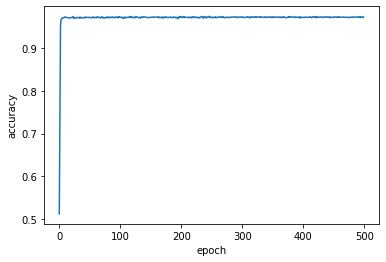

In [18]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.rcParams['figure.facecolor']='white'

In [19]:
@ct.electron
def evaluate_model(
    model: tf.keras.Model,
    predictors: pd.DataFrame,
    classes: pd.DataFrame
) -> float:
    
    cost, accuracy = model.evaluate(predictors, classes)
    
    return accuracy

# Generate test data and test the model
@ct.lattice
def test_model(
    model: tf.keras.Model, 
    nsamples: int, 
    num_elements: int, 
    dimensions: List[int]
) -> float:
    
    testing_predictors, testing_classes = ct.electron(generate_training_data)(
        nsamples=nsamples, num_elements=num_elements, dimensions=dimensions)
    
    testing_predictors, testing_classes = shuffle_training_data(
        predictors=testing_predictors, 
        classes=testing_classes
    )
    
    test_accuracy = evaluate_model(
        model=model, 
        predictors=testing_predictors, 
        classes=testing_classes
    )
    
    return test_accuracy

accuracy = ct.dispatch_sync(test_model)(
    model=model, 
    nsamples=nsamples, 
    num_elements=size, 
    dimensions=dims
).result
accuracy = test_model(model=model, nsamples=nsamples, num_elements=size, dimensions=dims)
print(f"Model Accuracy: {accuracy}")

INFO:tensorflow:Assets written to: ram://995fc4bc-8d7d-491f-a9a5-227497b41db8/assets
INFO:tensorflow:Assets written to: ram://415e694e-6876-4f06-8345-dc1c93796f56/assets
125/125 [==============================] - 0s 510us/step - loss: 0.5380 - accuracy: 0.9740
Model Accuracy: 0.9739999771118164


## Summary

In this tutorial we used Covalent in a variety of ways. In several sections we constructed workflows which we later combined into a larger workflow by making them sublattices.  Using the Covalent UI, we were able to visualize and track the progress of the experiments. An advanced user could even continue along the same path to examine how the number of epochs needed to learn to classify can change with the problem size.